### Imports and set up

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#torch imports 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from torcheeg.io.eeg_signal import EEGSignalIO
from torcheeg.models import DGCNN
from sklearn.model_selection import train_test_split
from torcheeg import transforms
from torcheeg.models.gnn.dgcnn import GraphConvolution
# helper sctipts 
from training import TrainNN
from cka import CKACalculator, HookManager

## Path constants
path="artifacts"
modelname="dgcnn_mod"
data_path = "../data/"
preprocessed_data_path = f"{path}/preprocessed_data.npy"

## Establish connection to datafile
IO = EEGSignalIO(io_path=str(data_path), io_mode='lmdb')

## Read metadata dataframeimports
metadata = pd.read_csv(data_path + 'sample_metadata.tsv', sep='\t')

### Load data

In [2]:
# Verifying connection to data
idxs = np.arange(len(metadata))

# Read features and labels as torch tensors
X = torch.FloatTensor(np.array([IO.read_eeg(str(i)) for i in idxs]))
y = torch.tensor(metadata["value"].values, dtype=torch.long)

In [3]:
bands = {"delta": [1, 4],"theta": [4, 8],"alpha": [8, 14],"beta": [14, 31],"gamma": [31, 49]}
if os.path.exists(preprocessed_data_path):
    
    with open(preprocessed_data_path, "rb") as f:
        X_bde = np.load(f)
    
else:
    t = transforms.BandDifferentialEntropy(band_dict=bands)

    X_bde = []
    for i in range(X.shape[0]):

        bde_tmp = t(eeg=X[i])
        X_bde.append(bde_tmp)

    X_bde = [x["eeg"] for x in X_bde]

    with open(preprocessed_data_path, "wb") as f:
        np.save(f, X_bde)

X_bde = torch.FloatTensor(X_bde)      

### Split data into train, validation and test sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_bde, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

assert X_train.shape[1]==X.shape[1],"Preprossed data lost channels"
assert X_train.shape[2]==len(bands),"Preprossed data does have incorrect amount of bands"
assert (X_train.shape[0]+X_val.shape[0]+X_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
assert (y_train.shape[0]+y_val.shape[0]+y_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"

In [5]:
# get dimensions

nsamples_train, nchannels_train, bands = X_train.shape
nsamples_val, nchannels_val, bands = X_val.shape

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

### Training & model hyperparameters

In [6]:
# Model parameters
num_chans = 5
num_electrodes = 22
num_outputs = y.max().item() + 1
num_layers = 2
hid_chans = 32

# Training parameters
lr = 1e-4
epochs = 40
w_decay = 0

#Models 
modruns = 3
plot=True
new_models=False

In [7]:
def plot_matrix(title,matrix_data,xlabel,ylabel):
    """
    Used for plotting our matrixis to unsure they are all the same format.

    ...
    Parameters
    ------------
    title : string
        The title on the plot
    matrix_data : np.ndarray
        The data for creating the heatmap
    xlabel : list
        A list of strings for the label marks
    ylabel : list
        A list of strings for the label marks
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(matrix_data,cmap='inferno',vmin=0,vmax=1)
    plt.xticks(ticks=np.arange(len(xlabel)), labels=xlabel)
    plt.yticks(ticks=np.arange(len(ylabel)), labels=ylabel)
    # Colourbar, with fixed ticks to enable comparison
    cbar = plt.colorbar()
    cbar.set_ticks([x/20 for x in range(0,21)])

    for i in range(matrix_data.shape[0]):  
        for j in range(matrix_data.shape[1]):
            plt.text(j, i, f"{matrix_data[i, j]:.2f}", ha='center', va='center', color='white' if matrix_data[i, j] < 0.5 else 'black')

    plt.title(title)
    ax = plt.gca()  
    ax.set_xticks(np.arange(len(xlabel)) - 0.5, minor=True)
    ax.set_yticks(np.arange(len(ylabel)) - 0.5, minor=True)
    ax.grid(which="minor", color="Black", linewidth=0.5)
    ax.tick_params(which="minor", size=0) 

    plt.show()

## Train model

### Train 4 models and calculate CKA matrices for pairs of models

In [8]:
mods = []

def train_models(model,modeltrainer,num_models=1,new =False, prints=False):
    """
    Training a model with random initialisation but consitent parameters. 
    
    Hyper parameters should be set outside of this function 
    
    path and model_names are both needed parameters that need to be defined outside of this function. 
    
    Path is to where your artifacts are located and model_name is what the model is called 
    
    ...
    
    Parameters
    -----------
    model : nn.modules
        The model being trained
    modeltrainer : training class
        a class for training the model provided should return a trained model
    num_models : int 
        Default 1, how many models it trains
    new : bool
        Weather it should attempt to use saved models
    """
    for i in range(num_models):
        
        tmp_mod = model(in_channels=num_chans, num_electrodes=num_electrodes, 
                              hid_channels=hid_chans, num_layers=num_layers, num_classes=num_outputs)
        model_path=f"{path}/{modelname}{i}.pth"
        print(f"Model {i}:")
        if new or not os.path.exists(model_path):    
            if not os.path.exists(model_path) and not new:
                print(f"Could not resolve path: {model_path}")
            trainer = modeltrainer()
            mods.append(trainer.train_model(tmp_mod, train_loader, val_loader, learning_rate=lr,path=path,name=modelname,
                                            w_decay=w_decay,epochs=epochs, prints=prints, modrun=i))
        else: 
            tmp_mod.load_state_dict(torch.load(model_path))
            tmp_mod.eval()
            mods.append([tmp_mod,[]])
            

# Training 4 models 
train_models(DGCNN,TrainNN,num_models=modruns,prints=plot, new=new_models)

Model 0:
Model 1:
Model 2:


## Functions to get activations of a layer type and calculated adjacency matrix

In [9]:
def get_activations(model, layer_type=[GraphConvolution]):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device).eval()
    hook_manager = HookManager(model, layer_type)
    model(X_train) # apparently a forward pass needs to be done for hooks to run
                   # this is just a placeholder so hooks get registered
    activations = hook_manager.get_activations()
    
    return activations

def get_adj_mat(model):
    
    return model.A.detach().cpu().numpy()

In [10]:
def visualize_adj_mat(adj_mat):

    plt.figure(figsize=(8, 6))
    plt.imshow(adj_mat, cmap='viridis', aspect='auto')
    plt.colorbar(label="Edge Strength")
    plt.title("Learned Adjacency Matrix")
    
    num_nodes = adj_mat.shape[0]
    node_labels = np.arange(1, num_nodes + 1)
    
    plt.xticks(ticks=np.arange(num_nodes), labels=node_labels)
    plt.yticks(ticks=np.arange(num_nodes), labels=node_labels)

    plt.xlabel("Nodes")
    plt.ylabel("Nodes")
    plt.show()

In [11]:
test_model = mods[0][0]

activations = get_activations(test_model)
adj_mat = get_adj_mat(test_model)


print(f"Extracted activations for {len(activations)} layers")
activations_shapes = [x.shape for x in activations.values()]
print(f"Extracted activations shapes: {activations_shapes}")
print(f"Adj matrix shape: {adj_mat.shape}")

Extracted activations for 2 layers
Extracted activations shapes: [torch.Size([3110, 22, 32]), torch.Size([3110, 22, 32])]
Adj matrix shape: (22, 22)


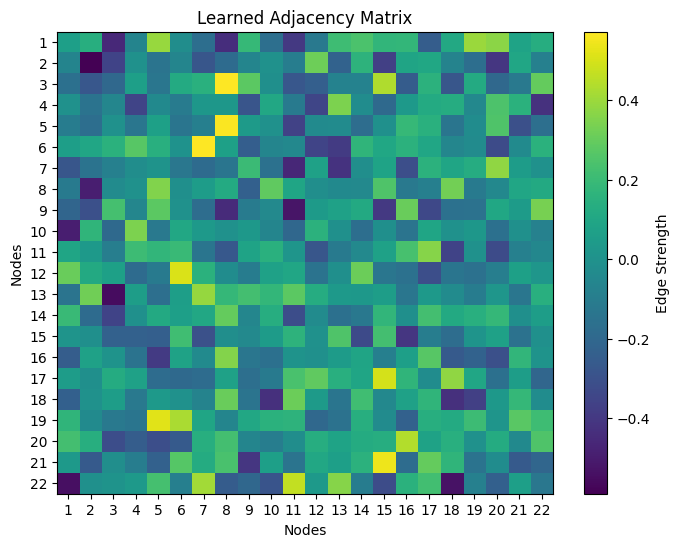

In [12]:
visualize_adj_mat(adj_mat)

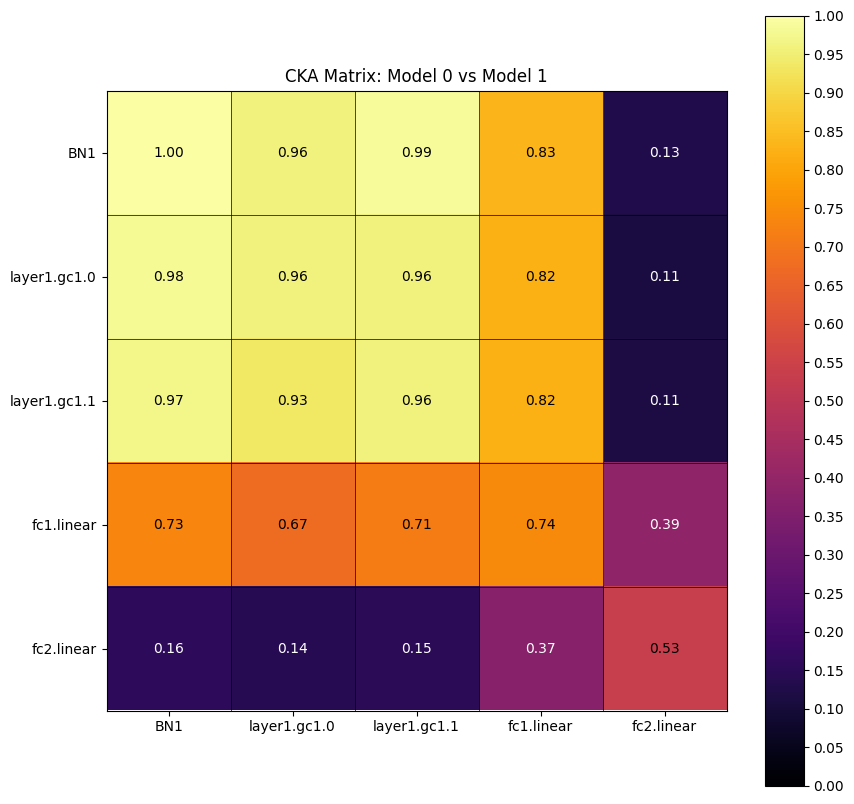

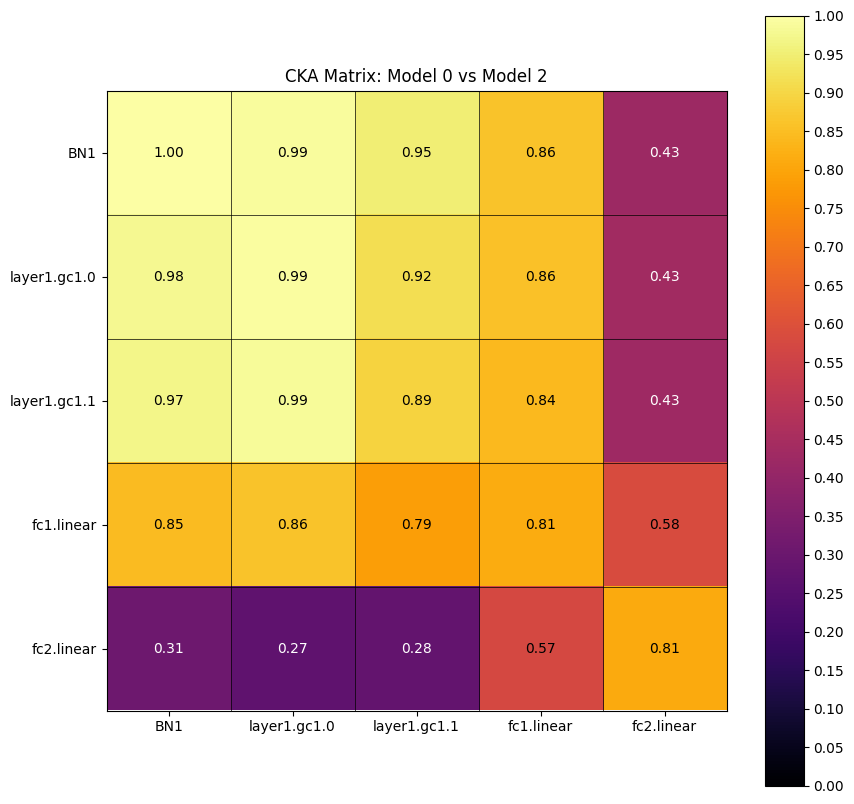

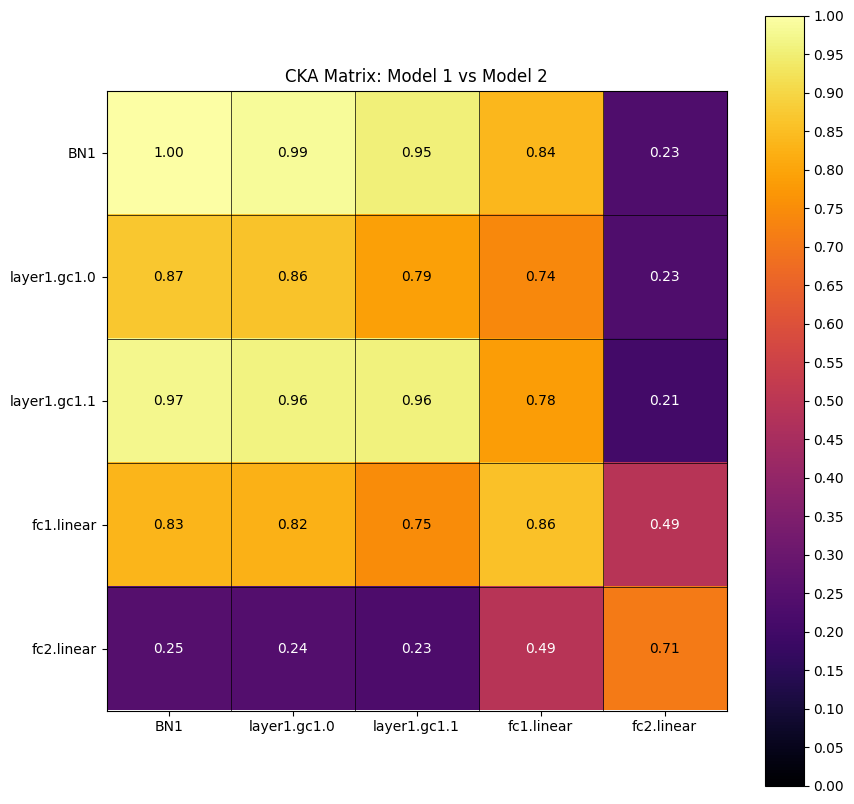

In [13]:
cka_all = []  
for i in range(modruns):
    for j in range(i+1,modruns):
        calculator = CKACalculator(model1=mods[i][0], model2=mods[j][0], dataloader=train_loader,
                                layers_to_hook=(nn.Conv2d, nn.Linear, nn.AdaptiveAvgPool2d, GraphConvolution, nn.BatchNorm1d))
        cka_output = calculator.calculate_cka_matrix()
        cka_all.append(cka_output)
        if plot:
            #Plot the matrix
            plot_matrix(f'CKA Matrix: Model {i} vs Model {j}',cka_output.cpu().numpy(),calculator.module_names_X,calculator.module_names_Y)


In [ ]:
num_test=10
Matrix_field_val = np.zeros(num_test)
for i in range(num_test):
    calculator = CKACalculator(model1=mods[0][0], model2=mods[1][0], dataloader=train_loader,
                                    layers_to_hook=(nn.Conv2d, nn.Linear, nn.AdaptiveAvgPool2d, GraphConvolution, nn.BatchNorm1d))
    cka_output = calculator.calculate_cka_matrix()
    Matrix_field_val[i]=cka_output[0][4]

In [21]:
print(f"Standard deviation: {np.std(Matrix_field_val)}")
print(f"Array max: {max(Matrix_field_val)}\nArray min: {min(Matrix_field_val)}\nArray mean: {np.mean(Matrix_field_val)}")


Standard deviation: 0.08551175796611611
Array max: 0.47562602162361145
Array min: 0.023415125906467438
Array mean: 0.14905441171489656


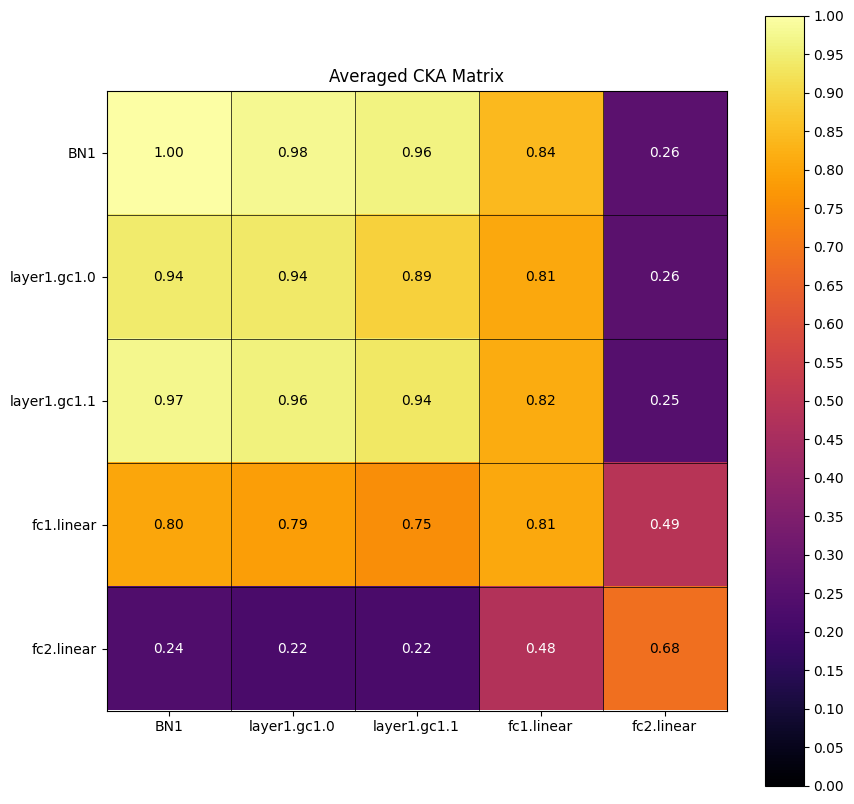

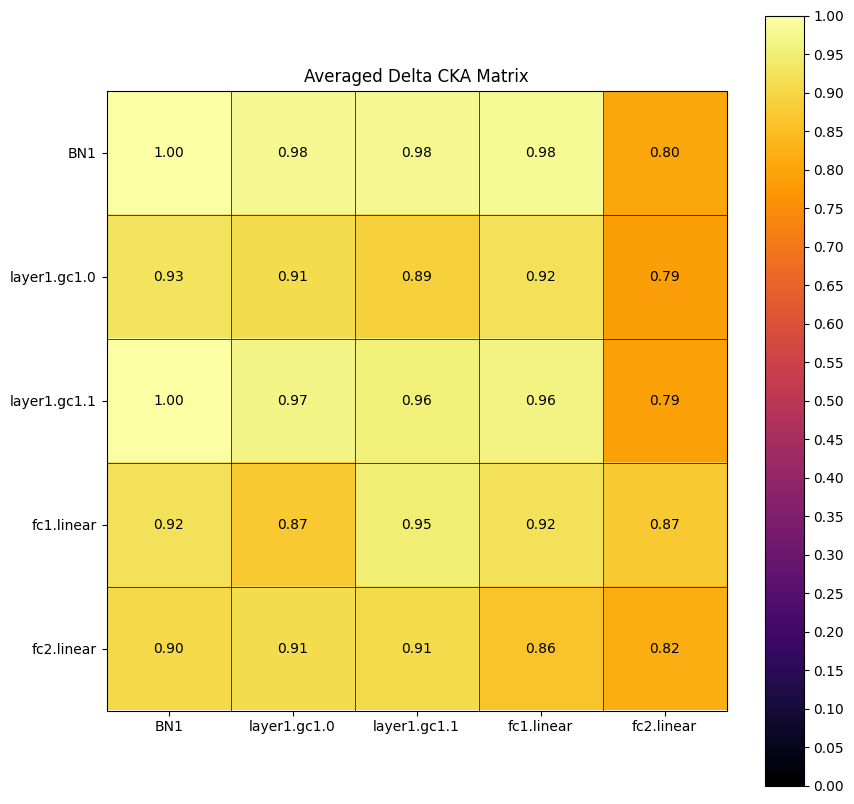

In [16]:
cka_stack = torch.stack(cka_all) 
average_cka_matrix = cka_stack.mean(dim=0)
delta_matrices = []

for i in range(len(cka_stack)):
    for j in range(i+1,len(cka_stack)):
        delta_matrices.append(torch.abs(cka_stack[i] - cka_stack[j])) 
        
delta_matrices = torch.stack(delta_matrices)  
average_delta_cka_matrix = 1- delta_matrices.mean(dim=0)  

plot_matrix("Averaged CKA Matrix",average_cka_matrix.cpu().numpy(),calculator.module_names_X,calculator.module_names_Y)

plot_matrix("Averaged Delta CKA Matrix",average_delta_cka_matrix.cpu().numpy(),calculator.module_names_X,calculator.module_names_Y)

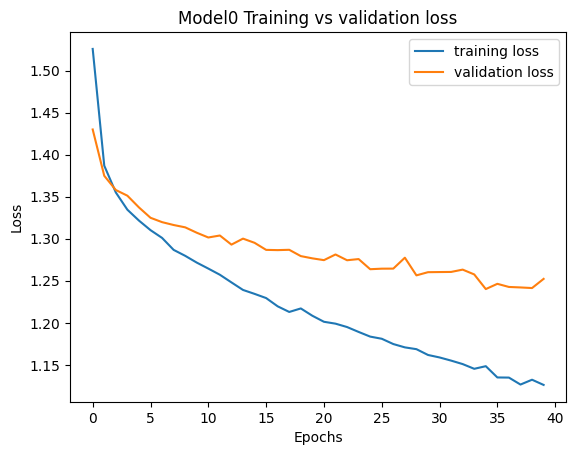

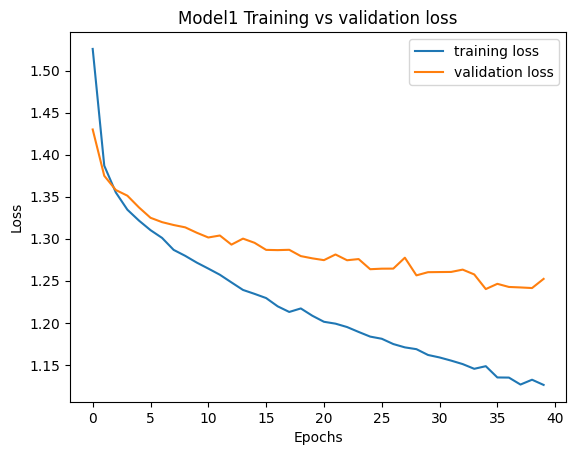

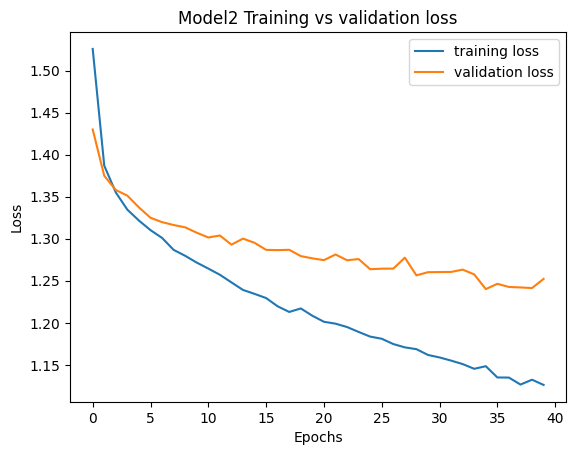

In [17]:
for i  in range (len(mods)):
    filepath=f"{path}/Training_validation_loss{i}.npy"
    if not new_models:
        try: 
            with open(filepath, "rb") as f:
                data = np.load(f)
        except:
            print(f"File with the data could not be found looking at address: {filepath}")
    else:
        with open(filepath, "wb") as f:
            np.save(f, mods[0][1])
            data = mods[0][1]
    plt.plot(data[0])
    plt.plot(data[1])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["training loss","validation loss"])
    plt.title(f"Model{i} Training vs validation loss")
    plt.show()
    